## Homework

### Getting the data

For this homework, we will use the **lead scoring Bank Marketing** dataset:

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-15 16:09:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.005s  

2025-10-15 16:09:23 (16.4 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not.

### Data preparation

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
leading_score = pd.read_csv("course_lead_scoring.csv")
leading_score.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


- Check if the missing values are presented in the features.

- If there are missing values:
    - For caterogiral features, replace them with `NA`

    - For numerical features, replace with with `0.0`

In [3]:
# Check for missing values
leading_score.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
# Fill missing values for categorical and numerical features
for col in leading_score.columns:
    if leading_score[col].dtype == 'object':
        leading_score[col] = leading_score[col].fillna('NA')
    else:
        leading_score[col] = leading_score[col].fillna(0.0)


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [5]:
# Split the data
from sklearn.model_selection import train_test_split 

df_full_train, df_test = train_test_split(leading_score, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance 

ROC AUC could also be used to evaluate feature importance of numerical variables.

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.

- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [6]:
from sklearn.metrics import roc_auc_score

# Select only numerical features
num = df_train.select_dtypes(include=['number']).columns.tolist()

auc_scores = {}

for feature in num:
    score = roc_auc_score(y_train, df_train[feature])
    
    # If AUC < 0.5, invert the feature
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    
    auc_scores[feature] = round(score, 3)

# Sort descending by AUC
sorted_auc = dict(sorted(auc_scores.items(), key=lambda x: x[1], reverse=True))

sorted_auc

{'number_of_courses_viewed': 0.764,
 'interaction_count': 0.738,
 'lead_score': 0.614,
 'annual_income': 0.552}

Which numerical variable (among the following 4) has the highest AUC? **`number_of_courses_viewed`**

### Question 2: Training the model 

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [18]:
from sklearn.feature_extraction import DictVectorizer

# Initialize DictVectorizer
dv = DictVectorizer(sparse=False)

# Select only categorical feature
cat = df_train.select_dtypes(include=['object']).columns.tolist()

# Fit and transform data
train_dict = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [27]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict on validation set
y_pred_val = model.predict_proba(X_val)[:, 1]

In [28]:
# Calculate AUC on validation set
auc = roc_auc_score(y_val, y_pred_val)
print(f'Validation AUC: {auc:.3f}')

Validation AUC: 0.817


What's the AUC of this model on the validation dataset? (round to 3 digits)

### Question 3: Precision and Recall 

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from `0.0` to `1.0` with step `0.01`

* For each threshold, compute precision and recall

* Plot them

In [20]:
# Define thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

In [23]:
from sklearn.metrics import precision_score, recall_score

# Get predicted probabilities for the positive class
y_pred_val = model.predict_proba(X_val)[:, 1]

precision = []
recall = []

for t in thresholds:
    y_pred = (y_pred_val >= t)
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


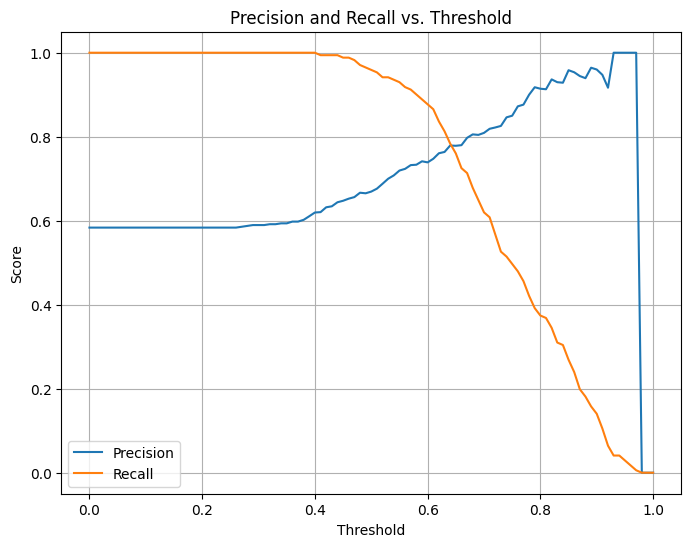

In [24]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

At which threshold precision and recall curves intersect?

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

### Question 5: 5-Fold CV

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`

* Split the data into train and validation

* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`

* Initialize `KFold` with the same parameters as previously

* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`

* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?